## Further text preprocessing

### Objectives of this test

- Implement Latent Dirichlet Allocation (**LDA**) from **Gensim** package along with the Mallet’s implementation (via Gensim). 

- Implement **Mallet** that optimizes LDA. Mallet is known to run faster and gives better topic segregation.

- Also extract the volume and percentage contribution of each topic to get **an idea of how important a topic is**.

### Pre-requisites: Downloading NLTK Dutch stopwords, data handling tools, model preprocessing & plotting tools, and SpaCy model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# NLTK
import nltk
nltk.download('stopwords', 'dutch')

[nltk_data] Downloading package stopwords to dutch...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Python data analysis tools and python module for printing
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [6]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [7]:
# SpaCy for lemmatization
import spacy

In [ ]:
# Plotting tools
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt

In [9]:
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

### Preparing stopwords

In [10]:
# NLTK Stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words('dutch')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading 628 articles into a list

In [11]:
# Importing file handling library
import os

data = []
path = 'drive/MyDrive/clean_texts/'
for name in os.listdir(path)[:628]:
    with open(path+name, 'r') as file:
        data.append(file.read())


### Tokenizing words and cleaning-up text

In [12]:
# Tokenizing each sentence into a list of words, removing punctuations and unnecessary characters altogether.
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

#print(data_words)

### Creating bigrams and trigrams

**Bigrams** are two (2) words frequently occurring together in the document. **Trigrams** are three (3) words frequently occurring.

In [13]:
# Building the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Seeing trigram example
#print(trigram_mod[bigram_mod[data_words]])

###  Removing stopwords, making bigrams & trigtrams, and lemmatizing

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

### Initializing SpaCy's Dutch NLP model (large size)

In [ ]:
 !pip install -U spacy
 !python -m spacy download nl_core_news_lg

### Calling the functions in order

In [15]:
 # Removing Stop Words
data_words_nostops = remove_stopwords(data_words)

# Forming Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Loading the SpaCy 'nl' model, keeping only tagger component (for efficiency)
nlp = spacy.load('nl_core_news_lg', disable=['parser', 'ner'])

# Doing lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized)

### Creating the Dictionary and Corpus needed for Topic Modeling

In [16]:
# Creating Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Creating Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Viewing corpus
#print(corpus)

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, **word id 0 occurs once** in the document. Likewise, **word id 1 occurs once too**, and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary. (From https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

In [17]:
# Passing the id as a key to the dictionary to see what word a given ID corresponds to
id2word[0]

'aanslagjaar'

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus]

### Building the topic model

The LDA model shall be built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

In [19]:
# Building LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

###  Viewing the topics in LDA model

You can see the keywords for each topic and the weightag (importance) of each keyword using lda_model.print_topics() as shown next.

In [20]:
# Printing keywords for 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.061*"artikel" + 0.043*"wetboek" + 0.039*"bedoelen" + 0.035*"goed" + '
  '0.031*"belasting" + 0.023*"lid" + 0.022*"lidstaat" + 0.021*"regeling" + '
  '0.017*"koninklijk" + 0.016*"btw"'),
 (1,
  '0.046*"overeenkomst" + 0.042*"akkoord" + 0.039*"generaal" + '
  '0.030*"toepassing" + 0.023*"bevoegde_autoriteiten" + '
  '0.020*"bevoegde_autoriteit" + 0.018*"grensarbeider" + 0.018*"paragraaf" + '
  '0.016*"verlenging" + 0.015*"dag"'),
 (2,
  '0.035*"decreet" + 0.033*"artikel" + 0.024*"Vlaams" + 0.023*"waals" + '
  '0.022*"lid" + 0.020*"regering" + 0.018*"besluit" + 0.014*"code" + '
  '0.014*"subsidie" + 0.011*"één"'),
 (3,
  '0.041*"steun" + 0.038*"onderneming" + 0.018*"betreffen" + '
  '0.016*"economisch" + 0.015*"bedoelen" + 0.015*"regering" + '
  '0.012*"brusselse_hoofdstedelijk" + 0.012*"minister" + 0.012*"deel" + '
  '0.012*"artikel"'),
 (4,
  '0.041*"artikel" + 0.019*"besluit" + 0.017*"ontwerp" + 0.016*"wet" + '
  '0.016*"lid" + 0.014*"maatregel" + 0.012*"bepaling" + 0.012*"be

**NOTE**: 

The weights reflect how important a keyword is to that topic.

Looking at these keywords, you can guess what this topic could be.

### Compute Model Perplexity and Coherence Score

**Model perplexity** and **topic coherence** provide a convenient measure to judge how good a given topic model is.

In [21]:
# Computing Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Computing Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.893673484587291

Coherence Score:  0.46444956574558544


### Visualizing topic-keywords distribution

In [22]:
# Feeding the model into the pyLDAvis instance
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.221797  0.133665       1        1  20.493795
4      0.205653 -0.020854       2        1  15.618683
12     0.154666  0.034087       3        1  12.640157
7      0.229978 -0.115887       4        1  11.009616
2      0.202935  0.055032       5        1   9.410017
17     0.172845  0.048095       6        1   6.627788
0      0.225983 -0.190319       7        1   5.833270
3      0.156572  0.055947       8        1   4.705815
10     0.129539  0.178345       9        1   2.784023
5      0.058172  0.224487      10        1   2.530728
8      0.026247 -0.162514      11        1   2.200914
14    -0.014412 -0.186005      12        1   2.127267
9     -0.021864 -0.075029      13        1   2.073705
1     -0.010209 -0.068771      14        1   1.110391
18    -0.273789  0.008021      15        1   0.449338
16    -0.296847  0.019975      16        1   0.170240
15    -0.294519  0.018192      17        1   0.099176
13    -0.292341  0.006056      18        1   0.085464
19    -0.291018  0.018691      19        1   0.028470
6     -0.289389  0.018785      20        1   0.001144, topic_info=                   Term          Freq         Total Category  logprob  loglift
564            regering   3118.000000   3118.000000  Default  30.0000  30.0000
243            minister   4211.000000   4211.000000  Default  29.0000  29.0000
483             decreet   1961.000000   1961.000000  Default  28.0000  28.0000
35                  lid   6254.000000   6254.000000  Default  27.0000  27.0000
7               artikel  14944.000000  14944.000000  Default  26.0000  26.0000
..                  ...           ...           ...      ...      ...      ...
25            hierboven      0.000311     47.323074  Topic20  -9.6664  -0.5554
26   hierboven_vermelde      0.000311     22.613752  Topic20  -9.6664   0.1830
27               hierna      0.000311    521.803203  Topic20  -9.6664  -2.9557
28         inde_xcijfer      0.000311      2.786006  Topic20  -9.6664   2.2770
29          indexcijfer      0.000311     43.979096  Topic20  -9.6664  -0.4821

[1202 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4708     10  0.942399  Af_bevelen
1502      1  0.210431    Brussels
1502      3  0.043840    Brussels
1502      8  0.061376    Brussels
1502     15  0.683901    Brussels
...     ...       ...         ...
63        9  0.005384         één
63       11  0.042801         één
63       12  0.001884         één
63       13  0.011575         één
63       14  0.003230         één

[2640 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 5, 13, 8, 3, 18, 1, 4, 11, 6, 9, 15, 10, 2, 19, 17, 16, 14, 20, 7])

**How to make inferences from pyLDAvis' output:**

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

## Mallet's version of LDA

Up next, we will improve upon this model by using **Mallet’s version of LDA algorithm** and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. 

In [ ]:
# Upgrading Gensim
# Updated to enforce Gensim v3.8 in Colab (the last version to support running topic models via Mallet).
# https://github.com/polsci/colab-gensim-mallet
!pip install --upgrade gensim==3.8

In [ ]:
# Installing Mallet
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [25]:
mallet_path = 'mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [26]:
# Showing Topics
pprint(ldamallet.show_topics(formatted=False))

[(18,
  [('code', 0.02634978041849651),
   ('waals', 0.02221648152932059),
   ('minister', 0.0216481529320589),
   ('artikel', 0.021286489279256006),
   ('nace_bel', 0.01958150348747094),
   ('bedoelen', 0.018806509945750453),
   ('onderneming', 0.018806509945750453),
   ('besluit', 0.018703177473521054),
   ('regering', 0.017773185223456472),
   ('decreet', 0.014259881167656936)]),
 (1,
  [('artikel', 0.04277378477874333),
   ('ontwerp', 0.026095013898975734),
   ('lid', 0.01677894367784428),
   ('wet', 0.01319776614660289),
   ('bepalen', 0.01277203175477699),
   ('bepaling', 0.012221081365355237),
   ('maatregel', 0.011770303774010168),
   ('advies', 0.01144474218026095),
   ('raad', 0.01106909418747339),
   ('bevoegdheid', 0.010242668603340763)]),
 (14,
  [('artikel', 0.057783479279379775),
   ('besluit', 0.034413519995537954),
   ('waals', 0.028557086284790006),
   ('lid', 0.022700652574042055),
   ('decreet', 0.022254448100842213),
   ('betreffen', 0.02197557030509231),
   ('woor

In [27]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4869767643836801


**NOTE:** A *slight increase* in **coherence score** from  **0.46444956574558544** to **0.4869767643836801**.

### Finding the optimal number of topics for LDA

The approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

In [29]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

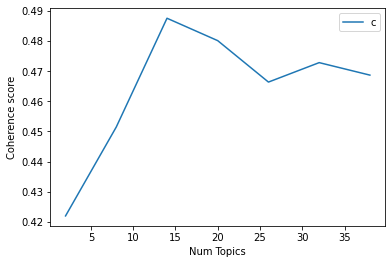

In [30]:
# Showing graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

**NOTE:**
The optimal **coherence score** shown in this plot lies **around 14 number of topics**.

In [31]:
# Printing the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.422
Num Topics = 8  has Coherence Value of 0.4514
Num Topics = 14  has Coherence Value of 0.4875
Num Topics = 20  has Coherence Value of 0.4801
Num Topics = 26  has Coherence Value of 0.4663
Num Topics = 32  has Coherence Value of 0.4728
Num Topics = 38  has Coherence Value of 0.4686


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out.

### Choosing the model with fourteen (14) topics

In [32]:
# Select the model and print the topics
# The best LDA model with the optimal coherence score has 14 topics, which is
# index 2 from the model_list list
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.037*"persoon" + 0.024*"cov_id" + 0.020*"artikel" + 0.013*"betreffen" + '
  '0.012*"gegeven" + 0.011*"vaccinatie" + 0.011*"coronavirus" + '
  '0.011*"bevoegd" + 0.009*"verwerking" + 0.008*"bepalen"'),
 (1,
  '0.017*"bedrag" + 0.014*"financieel" + 0.014*"ziekenhuis" + 0.013*"euro" + '
  '0.012*"artikel" + 0.011*"jaar" + 0.009*"instelling" + 0.008*"volgen" + '
  '0.008*"basis" + 0.008*"kost"'),
 (2,
  '0.026*"brusselse_hoofdstedelijk" + 0.019*"regering" + 0.019*"besluit" + '
  '0.015*"ordonnantie" + 0.014*"minister" + 0.014*"gewest" + '
  '0.012*"betrekking" + 0.011*"belasten" + 0.010*"belasting" + '
  '0.010*"administratie"'),
 (3,
  '0.030*"artikel" + 0.020*"bedoelen" + 0.016*"betreffen" + 0.015*"procedure" '
  '+ 0.015*"persoon" + 0.015*"kennisgeving" + 0.015*"fiscaal" + '
  '0.015*"akkoord" + 0.014*"inlichting" + 0.013*"toepassing"'),
 (4,
  '0.019*"cov_id" + 0.016*"artikel" + 0.014*"patiënt" + 0.011*"bepalen" + '
  '0.011*"voorzien" + 0.010*"verstrekking" + 0.008*"werknemer

### Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the **topic number that has the highest percentage contribution** in the document/set of documents.

In [33]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_words)

In [34]:
# Formatting
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Showing
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.7347,"artikel, wetboek, bedoelen, lid, goed, regelin...","[de, coefficient, bedoeld, in, artikel, van, h..."
1,1,2.0,0.4394,"brusselse_hoofdstedelijk, regering, besluit, o...","[filip, koning, der, belgen, aan, allen, die, ..."
2,2,5.0,0.5631,"besluit, koninklijk, wet, artikel, cov_id, min...","[verslag, aan, de, koning, sire, het, koninkli..."
3,3,11.0,0.6697,"artikel, besluit, onderwijs, decreet, betreffe...","[de, regering, van, de, franse, gemeenschap, g..."
4,4,10.0,0.2717,"onderneming, steun, artikel, code, bedoelen, b...","[de, waalse, regering, gelet, op, het, decreet..."
5,5,7.0,0.4446,"artikel, Vlaams, besluit, lid, decreet, vermel...","[het, vlaams, parlement, heeft, aangenomen, en..."
6,6,9.0,0.3213,"artikel, lid, woord, vervangen, wet, één, bedo...","[in, worden, de, woorden, pct, vervangen, door..."
7,7,13.0,0.3958,"regering, besluit, minister, overwegende, waal...","[de, regering, van, de, franse, gemeenschap, g..."
8,8,5.0,0.4133,"besluit, koninklijk, wet, artikel, cov_id, min...","[filip, koning, der, belgen, aan, allen, die, ..."
9,9,5.0,0.3022,"besluit, koninklijk, wet, artikel, cov_id, min...","[de, brusselse, hoofdstedelijke, regering, gel..."


### Finding the most representative document for each topic

With understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [35]:
# Grouping the top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reseting Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Formating
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Showing
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8710,"persoon, cov_id, artikel, betreffen, gegeven, ...","[filip, koning, der, belgen, aan, allen, die, ..."
1,1.0,0.8355,"bedrag, financieel, ziekenhuis, euro, artikel,...","[startende, vennootschappen, kunnen, moeilijkh..."
2,2.0,0.9438,"brusselse_hoofdstedelijk, regering, besluit, o...","[krachtens, artikel, van, het, koninklijk, bes..."
3,3.0,0.9013,"artikel, bedoelen, betreffen, procedure, perso...","[de, brusselse, hoofdstedelijke, regering, gel..."
4,4.0,0.8259,"cov_id, artikel, patiënt, bepalen, voorzien, v...","[verslag, aan, de, koning, sire, ik, heb, de, ..."


The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The **Perc_Contribution column** is nothing but the percentage contribution of the topic in the given document.

## Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. 

In [36]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenatinate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,8.0,"artikel, wetboek, bedoelen, lid, goed, regelin...",24.0,0.0382
1.0,2.0,"brusselse_hoofdstedelijk, regering, besluit, o...",33.0,0.0525
2.0,5.0,"besluit, koninklijk, wet, artikel, cov_id, min...",58.0,0.0924
3.0,11.0,"artikel, besluit, onderwijs, decreet, betreffe...",37.0,0.0589
4.0,10.0,"onderneming, steun, artikel, code, bedoelen, b...",31.0,0.0494
...,...,...,...,...
623.0,3.0,"artikel, bedoelen, betreffen, procedure, perso...",NaN,NaN
624.0,13.0,"regering, besluit, minister, overwegende, waal...",NaN,NaN
625.0,13.0,"regering, besluit, minister, overwegende, waal...",NaN,NaN
626.0,9.0,"artikel, lid, woord, vervangen, wet, één, bedo...",NaN,NaN


## CONCLUSION

From 628 Dutch legal text files that were cleaned, further ML preprocessing and unsupervised topic extraction were carried out via:

- A basic topic model using Gensim’s LDA; 

- pyLDAvis for topic visualisation; and 

- Mallet’s LDA implementation.